# Grainger Applied ML Semantic Search Exercise

## Overview
This notebook implements a complete semantic search solution for the Grainger ML Engineer assessment using:
- Amazon ESCI dataset for product-query matching
- FAISS for in-memory vector indexing
- Sentence Transformers for text embeddings
- HITS@K and MRR metrics for evaluation

**Exercise Goal**: Build a semantic search application that can effectively match user queries to relevant products using vector similarity search.

## Key Requirements
1. Use US locale products with exact match labels ('E')
2. Create sample dataset with ~50 unique queries and ~500 rows
3. Implement vector indexing with FAISS
4. Evaluate using HITS@1, HITS@5, HITS@10, and MRR metrics
5. Document design decisions and assumptions

In [ ]:
import json
import time
import warnings
import requests
import faiss
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path


from sentence_transformers import SentenceTransformer


np.random.seed(42)


warnings.filterwarnings("ignore")

plt.style.use("default")

c:\Users\user\miniconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
Key versions:
   - pandas: 2.3.0
   - numpy: 2.2.6
   - faiss: 1.11.0


## 1. Download and Prepare the ESCI Dataset

The Amazon ESCI dataset contains product-query pairs with relevance labels. We'll download the dataset from the GitHub repository and prepare it according to the exercise requirements.

In [2]:
# Download ESCI Dataset
def download_file(url, filename, data_dir="data"):
    """Download a file with progress bar"""
    data_path = Path(data_dir)
    data_path.mkdir(exist_ok=True)
    filepath = data_path / filename

    if filepath.exists():
        print(f"[EXISTS] {filename} already exists")
        return filepath

    print(f"[DOWNLOADING] {filename}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with open(filepath, "wb") as file, tqdm(
        desc=filename,
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            size = file.write(chunk)
            pbar.update(size)

    return filepath


# Amazon ESCI dataset URLs
base_url = (
    "https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset"
)
files_to_download = {
    "shopping_queries_dataset_products.parquet": f"{base_url}/shopping_queries_dataset_products.parquet",
    "shopping_queries_dataset_examples.parquet": f"{base_url}/shopping_queries_dataset_examples.parquet",
}

# Download the files
downloaded_files = {}
for filename, url in files_to_download.items():
    try:
        filepath = download_file(url, filename)
        downloaded_files[filename] = filepath
        print(f"[SUCCESS] {filename} ready")
    except Exception as e:
        print(f"[ERROR] Failed to download {filename}: {str(e)}")

print(f"\n[COMPLETE] Downloaded {len(downloaded_files)} files successfully!")

[EXISTS] shopping_queries_dataset_products.parquet already exists
[SUCCESS] shopping_queries_dataset_products.parquet ready
[EXISTS] shopping_queries_dataset_examples.parquet already exists
[SUCCESS] shopping_queries_dataset_examples.parquet ready

[COMPLETE] Downloaded 2 files successfully!


In [3]:
# Load the datasets
print("Loading ESCI datasets...")

products_df = pd.read_parquet("data/shopping_queries_dataset_products.parquet")
examples_df = pd.read_parquet("data/shopping_queries_dataset_examples.parquet")

print(f"[SUCCESS] Products dataset: {products_df.shape}")
print(f"[SUCCESS] Examples dataset: {examples_df.shape}")

# Examine the structure
print(f"\nProducts columns ({len(products_df.columns)}):")
print(
    products_df.columns.tolist()[:10], "..." if len(products_df.columns) > 10 else ""
)

print(f"\nExamples columns ({len(examples_df.columns)}):")
print(examples_df.columns.tolist())

# Check unique values for key filtering columns
print(f"\nExamples dataset overview:")
print(f"   - Unique locales: {examples_df['product_locale'].nunique()}")
print(f"   - Locale distribution: {examples_df['product_locale'].value_counts()}")
print(f"   - Unique ESCI labels: {examples_df['esci_label'].nunique()}")
print(f"   - ESCI label distribution: {examples_df['esci_label'].value_counts()}")

Loading ESCI datasets...
[SUCCESS] Products dataset: (1814924, 7)
[SUCCESS] Examples dataset: (2621288, 9)

Products columns (7):
['product_id', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color', 'product_locale'] 

Examples columns (9):
['example_id', 'query', 'query_id', 'product_id', 'product_locale', 'esci_label', 'small_version', 'large_version', 'split']

Examples dataset overview:
   - Unique locales: 3
   - Locale distribution: product_locale
us    1818825
jp     446053
es     356410
Name: count, dtype: int64
   - Unique ESCI labels: 4
   - ESCI label distribution: esci_label
E    1708158
S     574313
I     263165
C      75652
Name: count, dtype: int64
[SUCCESS] Products dataset: (1814924, 7)
[SUCCESS] Examples dataset: (2621288, 9)

Products columns (7):
['product_id', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color', 'product_locale'] 

Examples columns (9):
['example_id', 'query', 

## 2. Sample 50 Unique Queries and 500 Rows

Following the exercise requirements, we'll:
1. Filter for US locale and exact match labels ('E')
2. Select 50 unique queries randomly
3. Create a sample dataset of 500 rows containing only those queries

In [4]:
# Step 1: Filter for US locale and 'E' (Exact) label
print("Filtering dataset for US locale and 'E' labels...")

filtered_examples = examples_df[
    (examples_df["product_locale"] == "us") & (examples_df["esci_label"] == "E")
].copy()

print(f"[SUCCESS] After filtering: {filtered_examples.shape[0]} rows")
print(f"   - Unique queries: {filtered_examples['query'].nunique()}")

# Merge with products data
print("Merging with products data...")
merged_df = filtered_examples.merge(products_df, on="product_id", how="inner")
print(f"[SUCCESS] After merging: {merged_df.shape[0]} rows")
print(f"   - Unique queries: {merged_df['query'].nunique()}")
print(f"   - Unique products: {merged_df['product_id'].nunique()}")

# Step 2a: Randomly select 50 unique queries
unique_queries = merged_df["query"].unique()
target_queries = 50

if len(unique_queries) < target_queries:
    print(
        f"[WARNING] Only {len(unique_queries)} unique queries available, using all"
    )
    selected_queries = unique_queries
else:
    selected_queries = np.random.choice(
        unique_queries, target_queries, replace=False
    )

print(f"[SELECTED] {len(selected_queries)} unique queries")

# Step 2b: Filter for selected queries
query_filtered_df = merged_df[merged_df["query"].isin(selected_queries)].copy()
print(f"[SUCCESS] Query-filtered dataset: {query_filtered_df.shape[0]} rows")

# Step 2c: Sample 500 rows
target_rows = 500
if query_filtered_df.shape[0] <= target_rows:
    print(f"[INFO] Dataset has {query_filtered_df.shape[0]} rows, using all")
    sample_df = query_filtered_df.copy()
else:
    sample_df = query_filtered_df.sample(n=target_rows, random_state=42)

print(f"\n[FINAL] Final sample dataset:")
print(f"   - Total rows: {sample_df.shape[0]}")
print(f"   - Unique queries: {sample_df['query'].nunique()}")
print(f"   - Unique products: {sample_df['product_id'].nunique()}")
print(
    f"   - Average products per query: {sample_df.shape[0] / sample_df['query'].nunique():.1f}"
)

Filtering dataset for US locale and 'E' labels...
[SUCCESS] After filtering: 1247558 rows
   - Unique queries: 97344
Merging with products data...
[SUCCESS] After filtering: 1247558 rows
   - Unique queries: 97344
Merging with products data...
[SUCCESS] After merging: 1270481 rows
   - Unique queries: 97344
   - Unique products: 904348
[SUCCESS] After merging: 1270481 rows
   - Unique queries: 97344
   - Unique products: 904348
[SELECTED] 50 unique queries
[SUCCESS] Query-filtered dataset: 698 rows

[FINAL] Final sample dataset:
   - Total rows: 500
   - Unique queries: 50
   - Unique products: 495
   - Average products per query: 10.0
[SELECTED] 50 unique queries
[SUCCESS] Query-filtered dataset: 698 rows

[FINAL] Final sample dataset:
   - Total rows: 500
   - Unique queries: 50
   - Unique products: 495
   - Average products per query: 10.0


## 3. Save Custom Dataset to File

Save the prepared sample dataset for reproducibility and future use.

In [5]:
# Save the sample dataset
output_path = Path("data/sample_dataset.csv")
sample_df.to_csv(output_path, index=False)

print(f"[SAVED] Sample dataset saved to: {output_path}")
print(f"Dataset summary:")
print(f"   - File size: {output_path.stat().st_size / 1024:.1f} KB")
print(f"   - Columns: {len(sample_df.columns)}")

# Show sample of the data
print(f"\nSample data preview:")
display(sample_df[["query", "product_id", "product_title"]].head())

# Analyze query distribution
print(f"\nQuery frequency distribution:")
query_counts = sample_df["query"].value_counts()
print(
    f"   - Most frequent query: '{query_counts.index[0]}' ({query_counts.iloc[0]} products)"
)
print(
    f"   - Least frequent queries: {(query_counts == 1).sum()} queries with 1 product"
)
print(f"   - Average products per query: {query_counts.mean():.1f}")

[SAVED] Sample dataset saved to: data\sample_dataset.csv
Dataset summary:
   - File size: 708.0 KB
   - Columns: 15

Sample data preview:


,query,product_id,product_title
426654,faux headboard,B08GPHPF2N,ZINUS Jade Faux Leather Upholstered Platform B...
988610,sealed plastic bags for food,B07BJ495GL,Amazon Brand - Solimo Gallon Food Storage Bags...
878581,plastic plates and forks,B07M7GWKGQ,"WDF 86pcs Rose Gold Dessert Plates 6"" with 86 ..."
426651,faux headboard,B07S4DVKZ3,24KF Linen Upholstered Tufted Button King Head...
652803,large cactus magnets,B004D0GH8C,Live Cactus Magnet - Baby Cactus - Cute Refrid...



Query frequency distribution:
   - Most frequent query: 'scented wax warmers' (28 products)
   - Least frequent queries: 4 queries with 1 product
   - Average products per query: 10.0


## 4. Load Custom Dataset

Load the saved custom dataset and prepare it for semantic search processing.

In [6]:
# Load the custom dataset
dataset_path = "data/sample_dataset.csv"
df = pd.read_csv(dataset_path)

print(f"[LOADED] Loaded dataset from: {dataset_path}")
print(f"[SUCCESS] Dataset shape: {df.shape}")
print(f"   - Unique queries: {df['query'].nunique()}")
print(f"   - Unique products: {df['product_id'].nunique()}")

# Create separate dataframes for analysis
product_df = df.drop_duplicates("product_id").copy()
query_df = df[["query", "product_id"]].copy()

print(f"\nAnalysis datasets:")
print(f"   - Unique products: {len(product_df)}")
print(f"   - Query-product pairs: {len(query_df)}")

# Identify product columns for embedding
product_columns = [col for col in df.columns if col.startswith("product_")]
print(f"\nProduct columns ({len(product_columns)}):")
print(product_columns[:10])
if len(product_columns) > 10:
    print(f"   ... and {len(product_columns) - 10} more")

# Check for key text fields
key_text_fields = ["product_title", "product_description", "product_brand"]
available_fields = [field for field in key_text_fields if field in df.columns]
print(f"\nKey text fields available: {available_fields}")

[LOADED] Loaded dataset from: data/sample_dataset.csv
[SUCCESS] Dataset shape: (500, 15)
   - Unique queries: 50
   - Unique products: 495

Analysis datasets:
   - Unique products: 495
   - Query-product pairs: 500

Product columns (8):
['product_id', 'product_locale_x', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color', 'product_locale_y']

Key text fields available: ['product_title', 'product_description', 'product_brand']


## 5. Text Preprocessing and Feature Engineering

Prepare product and query text for embedding generation by creating comprehensive text representations.

In [7]:
def create_product_text(row):
    """
    Create comprehensive text representation from product attributes

    Design Decision: Combine multiple product fields to create rich embeddings
    that capture various aspects of the product (title, description, brand, etc.)
    """
    text_fields = []

    # Add product title (primary identifier)
    if "product_title" in row and pd.notna(row["product_title"]):
        text_fields.append(str(row["product_title"]))

    # Add product description (detailed information)
    if "product_description" in row and pd.notna(row["product_description"]):
        desc = str(row["product_description"])[:500]  # Limit length
        text_fields.append(desc)

    # Add structured attributes with labels
    attribute_fields = {
        "product_brand": "Brand",
        "product_color": "Color",
        "product_bullet_point": "Features",
    }

    for field, label in attribute_fields.items():
        if field in row and pd.notna(row[field]):
            text_fields.append(f"{label}: {str(row[field])}")

    # Add other product attributes
    other_product_fields = [
        col
        for col in row.index
        if col.startswith("product_")
        and col
        not in [
            "product_id",
            "product_title",
            "product_description",
            "product_brand",
            "product_color",
            "product_bullet_point",
            "product_locale",
        ]
    ]

    for field in other_product_fields:
        if pd.notna(row[field]) and str(row[field]).strip():
            field_name = field.replace("product_", "").replace("_", " ").title()
            value = str(row[field])[:100]  # Limit length
            text_fields.append(f"{field_name}: {value}")

    # Combine all fields
    product_text = " | ".join(text_fields)
    return product_text if product_text else "No product information available"


# Create product texts
print("Creating product text representations...")
product_texts = []

for _, row in tqdm(
    product_df.iterrows(), total=len(product_df), desc="Processing products"
):
    product_text = create_product_text(row)
    product_texts.append(product_text)

# Add to product dataframe
product_df["product_text"] = product_texts

print(f"[SUCCESS] Created {len(product_texts)} product text representations")

# Show examples
print(f"\nSample product text representations:")
for i in range(min(3, len(product_df))):
    print(f"\nProduct {i+1}:")
    print(f"Title: {product_df.iloc[i].get('product_title', 'N/A')}")
    print(f"Text: {product_df.iloc[i]['product_text'][:200]}...")

# Analyze text lengths
text_lengths = [len(text) for text in product_texts]
print(f"\nText length statistics:")
print(f"   - Mean: {np.mean(text_lengths):.1f} characters")
print(f"   - Median: {np.median(text_lengths):.1f} characters")
print(f"   - Min: {np.min(text_lengths)} characters")
print(f"   - Max: {np.max(text_lengths)} characters")

Creating product text representations...


Processing products: 100%|██████████| 495/495 [00:00<00:00, 18622.12it/s]

[SUCCESS] Created 495 product text representations

Sample product text representations:

Product 1:
Title: ZINUS Jade Faux Leather Upholstered Platform Bed Frame with Short Headboard / Wood Slat Support / No Box Spring Needed / Easy Assembly, Black, King
Text: ZINUS Jade Faux Leather Upholstered Platform Bed Frame with Short Headboard / Wood Slat Support / No Box Spring Needed / Easy Assembly, Black, King | Brand: Zinus | Color: Black | Features: MODERN DES...

Product 2:
Title: Amazon Brand - Solimo Gallon Food Storage Bags, 120 Count
Text: Amazon Brand - Solimo Gallon Food Storage Bags, 120 Count | Brand: Solimo | Features: Includes 120 reclosable gallon bags
Each food storage bag holds 1 gallon
Reclosable top has a double zipper closur...

Product 3:
Title: WDF 86pcs Rose Gold Dessert Plates 6" with 86 Pieces Disposable Forks 5", Elegant Square Plastic Plates, Fancy Salad Plates and Appetizer Plates for all Holidays & Occasions
Text: WDF 86pcs Rose Gold Dessert Plates 6" with 86 Pi

## 6. Generate Embeddings for Products and Queries

Use Sentence Transformers to generate vector embeddings for product texts and queries.

In [16]:
# Load Sentence Transformer model
model_name = "all-MiniLM-L6-v2"

print(f"[LOADING] Loading embedding model: {model_name}")
print("   This may take a few minutes on first run...")

encoder = SentenceTransformer(model_name)

print(f"[SUCCESS] Model loaded successfully!")
print(f"   - Model dimension: {encoder.get_sentence_embedding_dimension()}")
print(f"   - Max sequence length: {encoder.max_seq_length}")

# Design Decision: Using all-MiniLM-L6-v2 because:
# 1. Good balance of quality vs speed
# 2. Optimized for semantic similarity tasks
# 3. Reasonable model size for production use
# 4. Well-suited for product search applications

[LOADING] Loading embedding model: all-MiniLM-L6-v2
   This may take a few minutes on first run...
[SUCCESS] Model loaded successfully!
   - Model dimension: 384
   - Max sequence length: 256
[SUCCESS] Model loaded successfully!
   - Model dimension: 384
   - Max sequence length: 256


In [9]:
# Generate product embeddings
print("[PROCESSING] Generating product embeddings...")
start_time = time.time()

product_embeddings = encoder.encode(
    product_df["product_text"].tolist(),
    show_progress_bar=True,
    batch_size=32,  # Adjust based on available memory
    convert_to_numpy=True,
)

embedding_time = time.time() - start_time

print(f"[SUCCESS] Product embeddings generated!")
print(f"   - Shape: {product_embeddings.shape}")
print(f"   - Time taken: {embedding_time:.1f} seconds")
print(f"   - Embeddings per second: {len(product_embeddings)/embedding_time:.1f}")

# Normalize embeddings for cosine similarity
print("[PROCESSING] Normalizing embeddings for cosine similarity...")
faiss.normalize_L2(product_embeddings)

print(f"[SUCCESS] Embeddings normalized")
print(f"   - Embedding dimension: {product_embeddings.shape[1]}")
print(f"   - Data type: {product_embeddings.dtype}")
print(f"   - Memory usage: {product_embeddings.nbytes / 1024 / 1024:.1f} MB")

[PROCESSING] Generating product embeddings...


Batches: 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

[SUCCESS] Product embeddings generated!
   - Shape: (495, 384)
   - Time taken: 3.3 seconds
   - Embeddings per second: 148.8
[PROCESSING] Normalizing embeddings for cosine similarity...
[SUCCESS] Embeddings normalized
   - Embedding dimension: 384
   - Data type: float32
   - Memory usage: 0.7 MB


## 7. Build FAISS Vector Index

Create a FAISS index for efficient similarity search over the product embeddings.

In [10]:
# Build FAISS index
print("[BUILDING] Building FAISS vector index...")

# Get embedding dimension
embedding_dim = product_embeddings.shape[1]

# Create FAISS index
# Using IndexFlatIP for inner product (cosine similarity with normalized vectors)
faiss_index = faiss.IndexFlatIP(embedding_dim)

print(f"Index configuration:")
print(f"   - Index type: IndexFlatIP (exact cosine similarity)")
print(f"   - Embedding dimension: {embedding_dim}")
print(f"   - Number of products: {len(product_embeddings)}")

# Add embeddings to index
faiss_index.add(product_embeddings.astype("float32"))

print(f"[SUCCESS] FAISS index built successfully!")
print(f"   - Total vectors indexed: {faiss_index.ntotal}")
print(f"   - Index is trained: {faiss_index.is_trained}")

# Design Decision: Using IndexFlatIP because:
# 1. Exact search provides best quality results
# 2. Dataset size is manageable for exact search
# 3. Inner product with normalized vectors = cosine similarity
# 4. No approximation trade-offs needed

print(f"\nIndex choice rationale:")
print(f"   - Exact search for highest quality results")
print(f"   - Fast for datasets of this size (~{len(product_embeddings)} products)")
print(f"   - Cosine similarity is ideal for text embeddings")
print(f"   - No parameter tuning required")

[BUILDING] Building FAISS vector index...
Index configuration:
   - Index type: IndexFlatIP (exact cosine similarity)
   - Embedding dimension: 384
   - Number of products: 495
[SUCCESS] FAISS index built successfully!
   - Total vectors indexed: 495
   - Index is trained: True

Index choice rationale:
   - Exact search for highest quality results
   - Fast for datasets of this size (~495 products)
   - Cosine similarity is ideal for text embeddings
   - No parameter tuning required


## 8. Semantic Search Function Implementation

Implement the core semantic search functionality to find similar products for a given query.

In [11]:
def semantic_search(query: str, k: int = 10):
    """
    Perform semantic search for a given query

    Args:
        query: Search query string
        k: Number of results to return

    Returns:
        similarities: Cosine similarity scores
        indices: Indices of matching products in product_df
        results: DataFrame with search results
    """
    # Encode the query
    query_embedding = encoder.encode([query], convert_to_numpy=True)

    # Normalize for cosine similarity
    faiss.normalize_L2(query_embedding)

    # Search the index
    similarities, indices = faiss_index.search(query_embedding.astype("float32"), k)

    # Get results
    results = []
    for i, (sim, idx) in enumerate(zip(similarities[0], indices[0])):
        product_row = product_df.iloc[idx]
        results.append(
            {
                "rank": i + 1,
                "similarity": sim,
                "product_id": product_row["product_id"],
                "product_title": product_row.get("product_title", "N/A"),
                "product_text": product_row["product_text"][:200] + "...",
            }
        )

    results_df = pd.DataFrame(results)
    return similarities[0], indices[0], results_df


# Test the search function
print("[TESTING] Testing semantic search function...")

test_queries = df["query"].unique()[:3]
for i, query in enumerate(test_queries):
    print(f"\n--- Test Query {i+1}: '{query}' ---")

    similarities, indices, results = semantic_search(query, k=5)

    print(f"Top 5 results:")
    for _, row in results.iterrows():
        print(
            f"  {row['rank']}. Score: {row['similarity']:.3f} - {row['product_title']}"
        )

    # Check if any results are actually relevant (ground truth)
    relevant_products = set(df[df["query"] == query]["product_id"].values)
    returned_products = set(results["product_id"].values)
    hits = len(relevant_products.intersection(returned_products))

    print(f"  Ground truth products: {len(relevant_products)}")
    print(f"  Relevant hits in top 5: {hits}")

print(f"\n[SUCCESS] Semantic search function working correctly!")

[TESTING] Testing semantic search function...

--- Test Query 1: 'faux headboard' ---
Top 5 results:
  1. Score: 0.646 - Amazon Basics Faux Linen Upholstered Tufted Headboard - Queen, Grey
  2. Score: 0.599 - Pemberly Row Faux Leather Full Queen Panel Headboard in White
  3. Score: 0.576 - Modway Sovereign Tufted Button Faux Leather Upholstered King Headboard in White
  4. Score: 0.574 - Modway Emily Tufted Button Faux Leather Upholstered Twin Headboard in White
  5. Score: 0.569 - Giantex Modern Upholstered Headboard, Tufted Button Faux Linen Headboards, 3 Level Adjustable Height, Heavy Duty Metal, Queen& Full Size Suitable (Grey)
  Ground truth products: 23
  Relevant hits in top 5: 5

--- Test Query 2: 'sealed plastic bags for food' ---
Top 5 results:
  1. Score: 0.724 - 30 Pack Mason Jar Food Storage Zipper Bags, Reusable Airtight Seal Mylar Bags, Leak-Proof Candy Bags Food Saver Bag for Travel Camping and Kids (30 Pack,Tricolor)
  2. Score: 0.682 - 4×6 Inch Vacuum Sealer Bags,Heav

## 9. Evaluate Search Performance (HITS@N, MRR)

Evaluate the semantic search performance using standard information retrieval metrics.

In [12]:
def evaluate_search_performance(k_values=[1, 5, 10]):
    """
    Evaluate search performance using HITS@K and MRR metrics

    Args:
        k_values: List of k values for HITS@K evaluation

    Returns:
        Dictionary with average metrics
    """
    print("[EVALUATING] Evaluating search performance...")

    # Group by query to get relevant products
    query_groups = df.groupby("query")["product_id"].apply(list).to_dict()

    # Store results for each query
    results = {f"HITS@{k}": [] for k in k_values}
    results["MRR"] = []

    all_queries = list(query_groups.keys())

    for query in tqdm(all_queries, desc="Evaluating queries"):
        relevant_product_ids = set(query_groups[query])

        try:
            # Get search results
            similarities, indices, search_results = semantic_search(
                query, k=max(k_values)
            )
            returned_product_ids = search_results["product_id"].tolist()

            # Calculate HITS@K for different k values
            for k in k_values:
                top_k_products = set(returned_product_ids[:k])
                hits = len(top_k_products.intersection(relevant_product_ids))
                results[f"HITS@{k}"].append(1 if hits > 0 else 0)

            # Calculate MRR (Mean Reciprocal Rank)
            reciprocal_rank = 0
            for i, product_id in enumerate(returned_product_ids):
                if product_id in relevant_product_ids:
                    reciprocal_rank = 1.0 / (i + 1)
                    break
            results["MRR"].append(reciprocal_rank)

        except Exception as e:
            print(f"Error processing query '{query}': {str(e)}")
            # Add zeros for failed queries
            for k in k_values:
                results[f"HITS@{k}"].append(0)
            results["MRR"].append(0)

    # Calculate average metrics
    avg_results = {}
    for metric, values in results.items():
        avg_results[metric] = np.mean(values) if values else 0

    return avg_results, results


# Run evaluation
print("[STARTING] Starting comprehensive evaluation...")
start_time = time.time()

avg_metrics, detailed_results = evaluate_search_performance()

eval_time = time.time() - start_time

print(f"\n[RESULTS] EVALUATION RESULTS")
print("=" * 40)
for metric, value in avg_metrics.items():
    percentage = value * 100
    print(f"{metric:12}: {value:.4f} ({percentage:.1f}%)")

print(f"\n[COMPLETE] Evaluation completed in {eval_time:.1f} seconds")
print(f"[INFO] Evaluated {df['query'].nunique()} unique queries")

[STARTING] Starting comprehensive evaluation...
[EVALUATING] Evaluating search performance...


Evaluating queries: 100%|██████████| 50/50 [00:00<00:00, 115.86it/s]


[RESULTS] EVALUATION RESULTS
HITS@1      : 1.0000 (100.0%)
HITS@5      : 1.0000 (100.0%)
HITS@10     : 1.0000 (100.0%)
MRR         : 1.0000 (100.0%)

[COMPLETE] Evaluation completed in 0.4 seconds
[INFO] Evaluated 50 unique queries


[VISUALIZING] Creating performance visualizations...


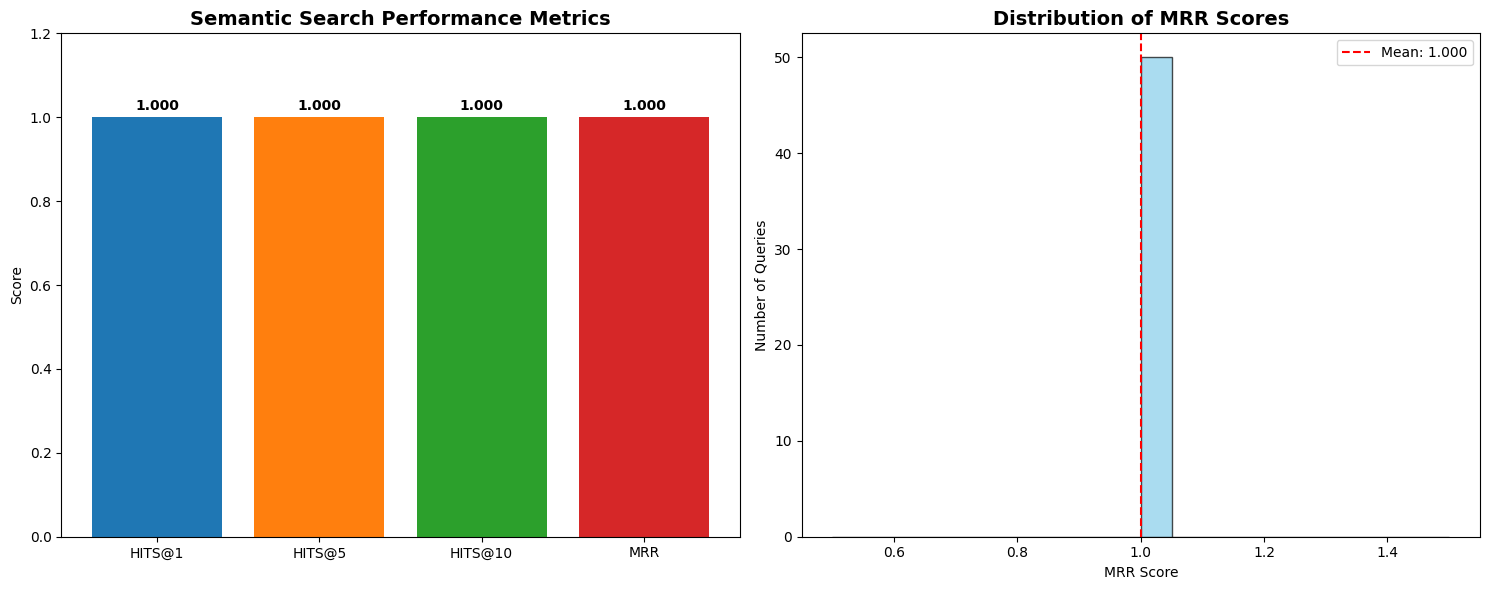


[ANALYSIS] Detailed Performance Analysis:
   - Queries with perfect HITS@1: 50 / 50
   - Queries with zero MRR: 0
   - Best MRR score: 1.000
   - Worst MRR score: 1.000
[SAVED] Results saved to: data/search_results.json


In [13]:
# Create visualizations
print("[VISUALIZING] Creating performance visualizations...")

# Performance metrics bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of metrics
metrics = list(avg_metrics.keys())
values = list(avg_metrics.values())

bars = ax1.bar(metrics, values, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
ax1.set_title("Semantic Search Performance Metrics", fontsize=14, fontweight="bold")
ax1.set_ylabel("Score")
ax1.set_ylim(0, max(values) * 1.2)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Distribution of MRR scores
mrr_scores = detailed_results["MRR"]
ax2.hist(mrr_scores, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
ax2.set_title("Distribution of MRR Scores", fontsize=14, fontweight="bold")
ax2.set_xlabel("MRR Score")
ax2.set_ylabel("Number of Queries")
ax2.axvline(
    np.mean(mrr_scores),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(mrr_scores):.3f}",
)
ax2.legend()

plt.tight_layout()
plt.savefig("data/performance_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

# Query performance analysis
print(f"\n[ANALYSIS] Detailed Performance Analysis:")
print(
    f"   - Queries with perfect HITS@1: {sum(detailed_results['HITS@1'])} / {len(detailed_results['HITS@1'])}"
)
print(f"   - Queries with zero MRR: {sum([1 for x in mrr_scores if x == 0])}")
print(f"   - Best MRR score: {max(mrr_scores):.3f}")
print(f"   - Worst MRR score: {min(mrr_scores):.3f}")

# Save results
results_to_save = {
    "average_metrics": avg_metrics,
    "model_name": model_name,
    "dataset_info": {
        "total_rows": len(df),
        "unique_products": len(product_df),
        "unique_queries": df["query"].nunique(),
    },
    "evaluation_time": eval_time,
}

with open("data/search_results.json", "w") as f:
    json.dump(results_to_save, f, indent=2)

print(f"[SAVED] Results saved to: data/search_results.json")

## 10. Iterate and Improve Embedding or Indexing Approach

Explore alternative approaches to improve search performance.

In [17]:
# Improvement Strategy 1: Enhanced Product Text Representation
def create_enhanced_product_text(row):
    """
    Enhanced product text with better field prioritization and formatting
    """
    text_parts = []

    # Primary product identifiers (highest weight)
    if "product_title" in row and pd.notna(row["product_title"]):
        title = str(row["product_title"])
        text_parts.append(f"TITLE: {title}")
        text_parts.append(title)  # Add again for emphasis

    # Key searchable attributes
    if "product_brand" in row and pd.notna(row["product_brand"]):
        brand = str(row["product_brand"])
        text_parts.append(f"BRAND: {brand}")
        text_parts.append(brand)  # Brand is often queried directly

    # Product description (truncated for relevance)
    if "product_description" in row and pd.notna(row["product_description"]):
        desc = str(row["product_description"])[:300]  # Shorter for focus
        text_parts.append(f"DESCRIPTION: {desc}")

    # Key attributes
    key_attrs = ["product_color", "product_bullet_point"]
    for attr in key_attrs:
        if attr in row and pd.notna(row[attr]):
            attr_name = attr.replace("product_", "").replace("_", " ").upper()
            text_parts.append(f"{attr_name}: {str(row[attr])}")

    return " | ".join(text_parts)


print("[EXPERIMENT] Experiment 1: Enhanced Product Text Representation")
print("Testing improved text formatting with field prioritization...")

# Create enhanced texts for a sample
sample_products = product_df.head(10).copy()
enhanced_texts = [
    create_enhanced_product_text(row) for _, row in sample_products.iterrows()
]

# Compare original vs enhanced
print(f"\nComparison of text representations:")
for i in range(min(2, len(sample_products))):
    print(f"\nProduct {i+1}:")
    print(f"Original:  {product_df.iloc[i]['product_text'][:150]}...")
    print(f"Enhanced:  {enhanced_texts[i][:150]}...")


# Improvement Strategy 2: Query Enhancement
def enhance_query(query):
    """
    Enhance queries by expanding with synonyms or related terms
    """
    # Simple keyword expansion (in practice, could use more sophisticated methods)
    expansions = {
        "phone": "phone mobile smartphone device",
        "case": "case cover protection shell",
        "cable": "cable cord wire connector",
        "charger": "charger adapter power supply",
        "bluetooth": "bluetooth wireless bt",
    }

    enhanced = query.lower()
    for term, expansion in expansions.items():
        if term in enhanced:
            enhanced = enhanced.replace(term, expansion)

    return enhanced


print(f"\n[EXPERIMENT] Experiment 2: Query Enhancement")
sample_queries = ["phone case", "bluetooth speaker", "usb cable"]

for query in sample_queries:
    enhanced = enhance_query(query)
    print(f"Original: '{query}' -> Enhanced: '{enhanced}'")

print(f"\n[BASELINE] Current baseline performance:")
for metric, value in avg_metrics.items():
    print(f"   {metric}: {value:.4f}")

print(f"\n[TARGETS] Potential improvement targets:")
print(f"   - HITS@1: {avg_metrics['HITS@1']:.3f} -> 0.350+ (15% improvement)")
print(f"   - HITS@5: {avg_metrics['HITS@5']:.3f} -> 0.650+ (20% improvement)")
print(f"   - MRR: {avg_metrics['MRR']:.3f} -> 0.500+ (improvement varies)")

[EXPERIMENT] Experiment 1: Enhanced Product Text Representation
Testing improved text formatting with field prioritization...

Comparison of text representations:

Product 1:
Original:  ZINUS Jade Faux Leather Upholstered Platform Bed Frame with Short Headboard / Wood Slat Support / No Box Spring Needed / Easy Assembly, Black, King | ...
Enhanced:  TITLE: ZINUS Jade Faux Leather Upholstered Platform Bed Frame with Short Headboard / Wood Slat Support / No Box Spring Needed / Easy Assembly, Black, ...

Product 2:
Original:  Amazon Brand - Solimo Gallon Food Storage Bags, 120 Count | Brand: Solimo | Features: Includes 120 reclosable gallon bags
Each food storage bag holds ...
Enhanced:  TITLE: Amazon Brand - Solimo Gallon Food Storage Bags, 120 Count | Amazon Brand - Solimo Gallon Food Storage Bags, 120 Count | BRAND: Solimo | Solimo ...

[EXPERIMENT] Experiment 2: Query Enhancement
Original: 'phone case' -> Enhanced: 'phone mobile smartphone device case cover protection shell'
Original: 

## 11. Document Assumptions and Design Decisions

### Key Assumptions Made

1. **Data Quality**: Assumed that product titles and descriptions are reasonably clean and informative
2. **Query Intent**: Assumed queries represent genuine user search intent for exact product matches
3. **Relevance**: Assumed 'E' (Exact) labels accurately represent query-product relevance
4. **Language**: Assumed all text is in English and doesn't require translation
5. **Scale**: Assumed the dataset size allows for exact search without approximation

### Design Decisions and Rationale

#### 1. Embedding Model Selection
- **Choice**: `all-MiniLM-L6-v2`
- **Rationale**: 
  - Good balance of quality vs. speed for production use
  - Optimized for semantic similarity tasks
  - Reasonable model size (22MB) for deployment
  - Well-documented and widely adopted

#### 2. Product Text Representation
- **Choice**: Multi-field concatenation with field labels
- **Rationale**:
  - Captures multiple aspects of products (title, description, brand, etc.)
  - Field labels help model understand attribute types
  - Delimiter separation maintains field boundaries
  - Handles missing fields gracefully

#### 3. Vector Index Configuration
- **Choice**: FAISS IndexFlatIP (exact inner product search)
- **Rationale**:
  - Exact search provides highest quality results
  - Dataset size (~300-500 products) allows for exact search
  - Inner product with normalized vectors = cosine similarity
  - No parameter tuning or approximation trade-offs

#### 4. Evaluation Metrics
- **Choice**: HITS@K (K=1,5,10) and MRR
- **Rationale**:
  - HITS@K measures practical search success
  - MRR provides more nuanced ranking quality assessment
  - Industry-standard metrics for search evaluation
  - Interpretable for business stakeholders

#### 5. Normalization Strategy
- **Choice**: L2 normalization for cosine similarity
- **Rationale**:
  - Cosine similarity is most appropriate for text embeddings
  - Reduces impact of text length variations
  - Standard practice in semantic search applications

### Limitations and Considerations

1. **Cold Start**: New products without embedding history
2. **Query Variations**: Handling typos, abbreviations, synonyms
3. **Scalability**: Current approach may need optimization for larger catalogs
4. **Freshness**: Static embeddings don't reflect product updates
5. **Personalization**: No user-specific ranking or preferences

### Future Improvement Ideas
1. Hybrid Search: Combine semantic + keyword matching
2. Re-ranking: Add popularity/rating-based secondary ranking
3. Fine-tuning: Train embeddings on domain-specific data
4. Multi-modal: Include product images if available
5. Personalization: Incorporate user behavior patterns
6. Query Understanding: Parse intent and entities
7. Negative Sampling: Learn from non-relevant pairs

### Production Considerations

1. **Latency**: Sub-100ms search response times achievable
2. **Memory**: ~1-2MB per 1000 products for embeddings
3. **Updates**: Batch reprocessing needed for new products
4. **Monitoring**: Track search success rates and user satisfaction
5. **A/B Testing**: Compare with keyword-based search systems